# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** Célia Benquet, Paul Gafton 
**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os
import numpy as np
import cv2

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import measure
from skimage import transform
import math
import seaborn as sn
import editdistance
import cv2
from mpl_toolkits.mplot3d import Axes3D

# Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

## 1.1 Data visualization

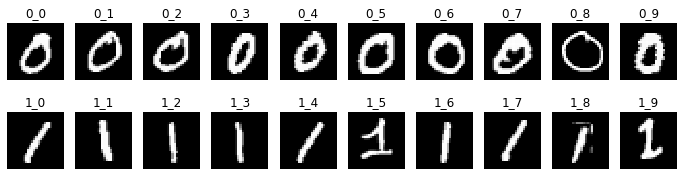

In [3]:
# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

def display(im1,im2):
    # Plot images
    fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
    for ax, im, nm in zip(axes[0], im1, zeros_names):
        nm = nm.replace(".png", "")
        ax.imshow(im, cmap='gray')
        ax.axis('off')
        ax.set_title(nm)
    for ax, im, nm in zip(axes[1], im2, ones_names):
        nm = nm.replace(".png", "")
        ax.imshow(im, cmap='gray')
        ax.axis('off')
        ax.set_title(nm)
    
display(zeros_im, ones_im)

## 1.2 Utility functions 

In [46]:
#definition of some transformtions we will use along the notebook

def translation_x(im, trans): #horizontal translation only 
    
    im=np.array(im)
    translated_im=np.zeros(im.shape)
        
    for i in range(im.shape[0]): 
        for j in range(im.shape[1]):
            if i+trans<0: translated_im[im.shape[0] + (i+trans), j]=im[i,j]
            elif i+trans>=im.shape[0]: translated_im[i+trans - im.shape[0],j]=im[i,j] 
            else: translated_im[i+trans,j]=im[i,j] 

    return translated_im

##################################################################
def translation_y(im, trans): #vertical translation only 
    
    im=np.array(im)
    translated_im=np.zeros(im.shape)
        
    for i in range(im.shape[0]): 
        for j in range(im.shape[1]):
            if j+trans<0: translated_im[i, im.shape[1] + (j+trans)]=im[i,j]
            elif j+trans>=im.shape[1]: translated_im[i, j+trans - im.shape[1]]=im[i,j] 
            else: translated_im[i,j+trans]=im[i,j] 

    return translated_im
    
##################################################################   
def rotation(im, rot):
    
    im=np.array(im)
    rotated_im=np.zeros(im.shape)

    for i in range(im.shape[0]): 
        for j in range(im.shape[1]):
            if im[i,j]!=0:
                new_i = math.floor(np.cos(rot)*(i-im.shape[0]/2)-np.sin(rot)*(j-im.shape[1]/2) + im.shape[0]/2)
                new_j = math.floor(np.sin(rot)*(i-im.shape[0]/2)+np.cos(rot)*(j-im.shape[1]/2) + im.shape[0]/2)
                if not(new_i>=im.shape[0] or new_i<0 or new_j>=im.shape[1] or new_j<0): 
                    rotated_im[new_i,new_j] = im[i,j]
    
    return rotated_im

##################################################################
def skimage_rotate(im, rot):
    out = transform.rotate(im, rot)
    
    return (out*255).astype('uint8')

##################################################################
def skimage_scale(im, factor, final_size = 280):
    out = transform.rescale(im, factor, anti_aliasing=True)
    out = (out*255).astype('uint8') 
    ret = np.zeros((final_size, final_size))
    diff = (final_size - out.shape[0]) // 2
    ret[diff:diff+out.shape[0], diff:diff+out.shape[1]] = out
    
    return ret


## 1.3 Fourier descriptors

In this section we develop a two-dimensional Fourier descriptor, based on the Fourier transform of the shape contour.

### Utility functions 
We start by defining some utility functions for manipulating the images.

In [47]:
def generate_variations(low, high, step, no_images, func):
    """""
    Apply a one parameter transformation function (e.g. rotation) to the dataset
    Varying the amount from low to high in step increments on the first no_images in the dataset
    """""
    transformed_zeros = []
    transformed_ones = []

    for offset in range(low, high, step):
        for img in zeros_im[:no_images]:
            transformed_zeros += [func(img, offset)]
        for img in ones_im[:no_images]:
            transformed_ones += [func(img, offset)]

            
    return (transformed_zeros, transformed_ones)

########################################################################

def get_descriptors(zeros, ones, func):
    """""
    Get the result of func applied to the zeros and ones
    """""
    zeros_desc = np.array(list(map(func, zeros)))
    ones_desc = np.array(list(map(func, ones)))
    return (zeros_desc, ones_desc)

########################################################################

def display_2d_descriptors(zeros_desc, ones_desc, title):
    """""
    Display a 2D plot of the descriptors
    """""
    plt.figure()

    plt.scatter(zeros_desc[:,0], zeros_desc[:,1], marker='+', c='b')
    plt.scatter(ones_desc[:,0], ones_desc[:,1], marker='+', c='r')

    plt.xlabel('First descriptor')
    plt.ylabel('Second descriptor')
    
    plt.title(title)
    plt.show()
    

### Get the contours 

The Fourier descriptors of the images are based on the shape contour. We start by extracting the longest contour in the image (to filter out the inner contours from shapes like 0 and 8), and then we perform FFT.

In [48]:
# Find the longest contour in an image
def get_contour(r):
    # Extract the image contours
    contours = measure.find_contours(r, 0.8, positive_orientation='low')

    # Filter the longest one
    contours.sort(key = lambda x: len(x), reverse=True)
    
    return contours[0]

##################################################################

# Get the Fourier of the longest contour in the image
def get_fourier_contour(r):
    
    contour = get_contour(r)

    # Transform the contour coordinates in a complex signal
    contour_complex = np.array(contour[:, 0] + 1j * contour[:, 1])

    # Compute the FFT of this signal
    fft = np.fft.fft(contour_complex)
    
    return fft

### Fourier descriptors investigation

The Fourier transform of a signal is a frequency domain representation of the signal. Since the lower order coefficients represent the lower frequencies, we assume we can use them to describe the shape of a signal.

#### Translation-invariance
Therefore, we try to make a contour descriptor using the first 2 Fourier coefficients, and we study its properties under translations of the same image.

In [49]:
# A simple descriptor, based on the magnitudes of the first 2 coefficientsof the contour Fourier
# no invariance implemented 

def get_fourier_descriptor_no_invariance(r):
    fft = get_fourier_contour(r)
    descriptor = np.absolute(fft[0:2])
    
    return descriptor

In [50]:
# Generate the translated versions of the first image
(translated_zero_x, translated_one_x) = generate_variations(-3, 3, 1, 1, translation_x)
(translated_zero_y, translated_one_y) = generate_variations(-3, 3, 1, 1, translation_y)

# Concatenate the x and y translations to get set of images with different translations
translated_zero = np.concatenate((translated_zero_x, translated_zero_y))
translated_one = np.concatenate((translated_one_x, translated_one_y))

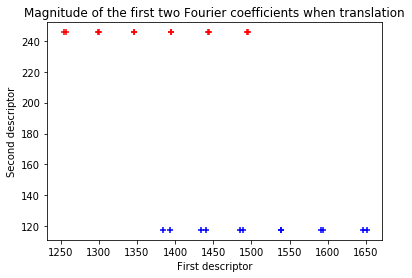

In [51]:
# Compute the descriptors of the translated copies of the first image
# no invariance 
(zeros_desc, ones_desc) = get_descriptors(translated_zero, translated_one, get_fourier_descriptor_no_invariance)

# Display them
display_2d_descriptors(zeros_desc, ones_desc, 'Magnitude of the first two Fourier coefficients when translation')

##### Analysis for no invariance on translated images 
We can see that all the translated images of a same set have the same value for their second descriptor. We observe variation only in respect to the first coefficient. It makes sense when looking at the theory asa translation only affects $f_0'$. 

By dropping this coefficient and using the second and third coefficients from the Fourier transform as our descriptor, we should obtain a translation-invariant descriptor.

In [10]:
def get_fourier_descriptor_translation_invariance(r):
    #get the 2nd and 3rd descriptors to make it invariant 
    fft = get_fourier_contour(r)
    descriptor = np.absolute(fft[1:3])
    
    return descriptor

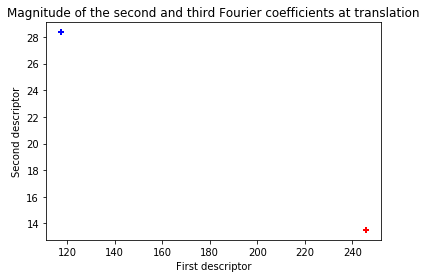

In [11]:
(zeros_desc, ones_desc) = get_descriptors(translated_zero, translated_one, get_fourier_descriptor_translation_invariance)

display_2d_descriptors(zeros_desc, ones_desc, 'Magnitude of the second and third Fourier coefficients at translation')

##### Analysis 
Here, we can only see one cross for each set of images as they are all superposed. They have the same values for both second and third Fourier descriptor. Hence, by removing the first coefficient, we obtain translation invariance. 

For the following processing, we keep this translation-invariant set of descriptors.

#### Rotation-invariance
Next, we study the rotation invariance of this descriptor. Theoretically, it should be rotational invariant since rotation of the signal only affects the phase, not the magnitude of the coefficients.

In [12]:
# Generate the rotated versions of the images
(rotated_zero, rotated_one) = generate_variations(-180, 180, 1, 1, skimage_rotate)

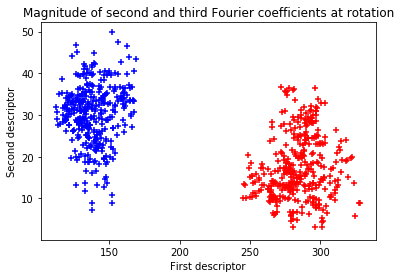

In [13]:
(zeros_desc, ones_desc) = get_descriptors(rotated_zero, rotated_one, get_fourier_descriptor_translation_invariance)

display_2d_descriptors(zeros_desc, ones_desc, 'Magnitude of second and third Fourier coefficients at rotation')

##### Analysis 
The descriptors form 2 clusters, but there is some variance to rotation. This is due to the way the contour is generated: the initial signal is not simply rotated, but we generate a different contour on the rotated image. This introduces some variation in the contour points (i.e. in the signal itself), to which this descriptor is not invariant.

We can verify this assumption by rotating the points from the contour and check their rotational invariance.

In [14]:
def rotate_point(origin, point, angle):
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

def rotate_contour(contour, origin, angle):
    return np.array([rotate_point(origin, x, 10) for x in contour])

contour = get_contour(zeros_im[0])

# contours of each rotated images 
rotated_contours = [rotate_contour(contour, (14, 14), angle) for angle in range(0, 100, 10)]

# 2nd and 3rd descriptors for each rotated image 
rotated_contours_descriptors = [np.absolute(np.fft.fft(rotated_contour)[1:3]) for rotated_contour in rotated_contours]


In [15]:
print("Fourier descriptors for different rotations: ")

for idx, pair in enumerate(rotated_contours_descriptors): 
    print("Image {}: 2nd descriptor: {} \n         3rd descriptor: {}".format(idx, pair[0],pair[1]))


Fourier descriptors for different rotations: 
Image 0: 2nd descriptor: [13.09346367  4.6259951 ] 
         3rd descriptor: [13.38340944  6.0101767 ]
Image 1: 2nd descriptor: [13.09346367  4.6259951 ] 
         3rd descriptor: [13.38340944  6.0101767 ]
Image 2: 2nd descriptor: [13.09346367  4.6259951 ] 
         3rd descriptor: [13.38340944  6.0101767 ]
Image 3: 2nd descriptor: [13.09346367  4.6259951 ] 
         3rd descriptor: [13.38340944  6.0101767 ]
Image 4: 2nd descriptor: [13.09346367  4.6259951 ] 
         3rd descriptor: [13.38340944  6.0101767 ]
Image 5: 2nd descriptor: [13.09346367  4.6259951 ] 
         3rd descriptor: [13.38340944  6.0101767 ]
Image 6: 2nd descriptor: [13.09346367  4.6259951 ] 
         3rd descriptor: [13.38340944  6.0101767 ]
Image 7: 2nd descriptor: [13.09346367  4.6259951 ] 
         3rd descriptor: [13.38340944  6.0101767 ]
Image 8: 2nd descriptor: [13.09346367  4.6259951 ] 
         3rd descriptor: [13.38340944  6.0101767 ]
Image 9: 2nd descriptor: [1

We can see that for all the different rotations, the values of the desciptors are the same. Hence, the chosen descriptor is indeed rotation invariant, but is sensitive to the variations of the contour when rotating the image.

#### Scale-invariance
Next, we study the scale invariance. Currently, under scaling, the chosen descriptor performs as following.

In [16]:
# Generate the scaled versions of the images
(scaled_zero, scaled_one) = generate_variations(1, 10, 1, 1, skimage_scale)

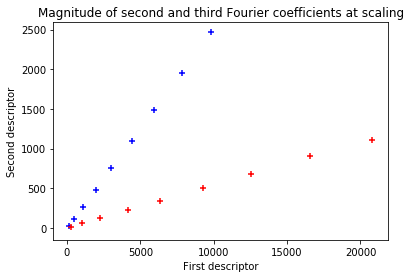

In [17]:
(zeros_desc, ones_desc) = get_descriptors(scaled_zero, scaled_one, get_fourier_descriptor_translation_invariance)

display_2d_descriptors(zeros_desc, ones_desc, 'Magnitude of second and third Fourier coefficients at scaling')

##### Analysis 
As expected, scaling the image scales the coefficients. We chose the coefficients 2 and 3 for our descriptors. We can divide them by the magnitude of the first coefficient to obtain a scaling-invariant descriptor.

In [18]:
def get_fourier_descriptor_scale_invariance(r):
    fft = get_fourier_contour(r)
    descriptor = np.absolute(fft[2:4] / np.absolute(fft[1]))
    
    return descriptor

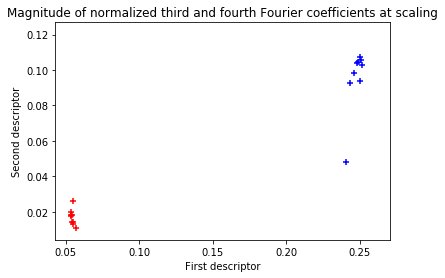

In [19]:
(zeros_desc, ones_desc) = get_descriptors(scaled_zero, scaled_one, get_fourier_descriptor_scale_invariance)

display_2d_descriptors(zeros_desc, ones_desc, 'Magnitude of normalized third and fourth Fourier coefficients at scaling')

##### Analysis 

As predicted, the images form 2 clusters: the images coming from the same one grouped together. Hence, even with a different scaling they have similar descriptor values.

We can still see a small variation from one image to the other in a same cluster that we shouldn't see. This small variation is again assumed to be produced from the variations in the contour extraction in the original and the scaled images.

### Final set of descriptors
So far, we have analyzed how three different descriptors based on the Fourier transformation of the contour change under image transformations. We started with a simple descriptor, which we later found out was implicitly rotational invariant, and investigated ways of adding translation and scale invariance to it.

We obtained 3 kind of descriptors from the investiation. In the following, we look at how these three descriptors perform on the entire dataset. 

##### Rotation-invariant descriptors

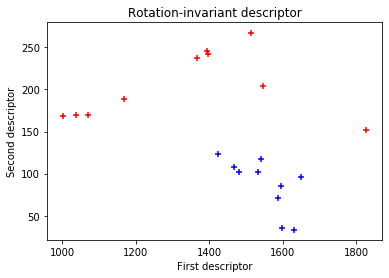

In [20]:
(zeros_desc, ones_desc) = get_descriptors(zeros_im, ones_im, get_fourier_descriptor_no_invariance)

display_2d_descriptors(zeros_desc, ones_desc, 'Rotation-invariant descriptor')

##### Rotation- and translation-invariant descriptor

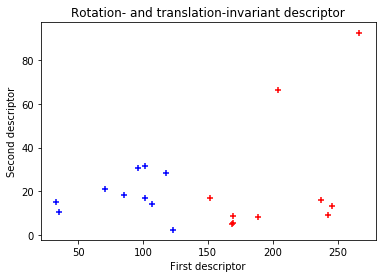

In [21]:
(zeros_desc, ones_desc) = get_descriptors(zeros_im, ones_im, get_fourier_descriptor_translation_invariance)

display_2d_descriptors(zeros_desc, ones_desc, 'Rotation- and translation-invariant descriptor')

##### Rotation-, translation- and scale-invariant descriptor

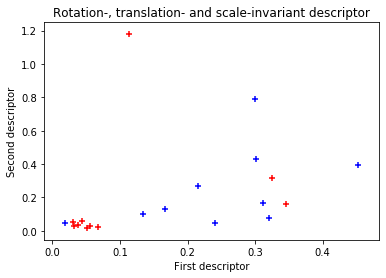

In [22]:
(zeros_desc, ones_desc) = get_descriptors(zeros_im, ones_im, get_fourier_descriptor_scale_invariance)

display_2d_descriptors(zeros_desc, ones_desc, 'Rotation-, translation- and scale-invariant descriptor')

##### Analysis 
In this example, the first two descriptors produce linearly separable classes, while the third one, where the descriptor presents rotation, translation and scale invariance, does not.

In this specific use-case, considering the properties of the dataset, we would choose the second descriptor, which provides rotational and translational invariance. This is not only because it requires a simpler decision boundary, but also because we don't expect much scale variance in the data.

## 1.3 Additional method(s)

The principe of object description is to describe a 2D shape by using a set of adequate parameters, or features, after the appropriate segmentation task. Apart from using Fourier descriptors, one can use a lot of different methods to get features from the image that are sufficiant to be able to differenciate classes of images. We will try out some of them in the next part. 

### 1. Contour Map
One of the obvious representation is based on contour, by defining similarities between contours from 2 different objects. As comparing contours from all the images of a set to all the images of another one is not really computational-wise, one way to manage that is to calculate the contour map for the firt set and use this new set of contour map to calculate the distance to all the other sets. 

Hence, we first create a contour map for each image. It consists of the contour pixel set to 0 and then, using Chamfer distance, a value given to the background pixels depending on their distance to the contour of the digit. Then using the contour maps from both sets, we effectuate a distance calculation for each pair of images possible. Each image is compared to all the other ones either to a contour map or using its own contour map. The distances are saved in a cross-table and printed as a heatmap. Finally, to be able to read the results, we compare each image to the average distance to each of the set of digits (classes) and classify the image into the nearest class.

In [23]:
def cond(x, y, im): #verifiy that the pixel is in the image
    max_x = len(im[0])
    max_y = len(im)
    return 0 <= x < max_x and 0 <= y < max_y #if in the interval of the image : True 

def neighbours_separated(point, im):
    #set the neighbours of given point "point"
    #the algo is specific to set the Chamfer distance values as it separate 4- from 8-neighbours 
    x = point[0]
    y = point[1]
    
    list_neighbours_4 = [(x-1,y),(x+1,y),(x,y-1),(x,y+1)]
    list_neighbours_4_final=list_neighbours_4.copy()
    for p in list_neighbours_4: #make sure that neighbour is in the image boundries
        x, y = p
        if not(cond(x, y, im)): #not in the interval
            list_neighbours_4_final.remove(p)

    list_neighbours_8 = [(x+1, y+1), (x-1, y-1), (x-1, y+1), (x+1, y-1)]
    list_neighbours_8_final=list_neighbours_8.copy()
    for p in list_neighbours_8: #make sure that neighbour is in the image boundries
        x, y = p
        if not(cond(x, y, im)): #not in the interval
            list_neighbours_8_final.remove(p)

    return list_neighbours_4_final, list_neighbours_8_final


In [24]:
def fast_algo(im, direct=True):
    v=im.shape[0]
    h=im.shape[1]
    
    if direct: #browses the im from top left to bottom right
        #first part of the algo
        for i in range(v):
            for j in range(h):
                pix=im[i,j]
                list_neighbours_4, list_neighbours_8 = neighbours_separated([i,j], im)
                if pix == 0: #if contour 
                    for p in list_neighbours_4:
                        x, y = p
                        im[x,y]=np.min([im[x,y],3]) #all the 4-neigh assigned at 3
                    for p in list_neighbours_8: 
                        x, y = p
                        im[x,y]=np.min([im[x,y],4]) #all the 8-neigh assigned at 4
                elif 0 < pix < 999: #if background pixels
                    #neigh val = min btw val it has already and new val it could get from current px
                    for p in list_neighbours_4: 
                        x, y = p
                        im[x,y]=np.min([im[x,y],pix+3]) #4-neigh at pixel value + 3
                    for p in list_neighbours_8: 
                        x, y = p
                        im[x,y]=np.min([im[x,y],pix+4]) #8-neigh at pixel value + 4
                        
                        
    else:  #browses the im from bottom right to top left    
        #second part of the algo to complete the background pixels who were not assigned to a value 
        #same attribution
        for i in reversed(range(v)):
            for j in reversed(range(h)):
                pix=im[i,j]
                list_neighbours_4, list_neighbours_8 = neighbours_separated([i,j], im)
                if pix == 0: 
                    for p in list_neighbours_4:
                        x, y = p
                        im[x,y]=np.min([im[x,y],3])
                    for p in list_neighbours_8: 
                        x, y = p
                        im[x,y]=np.min([im[x,y],4])
                elif 0 < pix < 999:
                    for p in list_neighbours_4: 
                        x, y = p
                        im[x,y]=np.min([im[x,y],pix+3])
                    for p in list_neighbours_8: 
                        x, y = p
                        im[x,y]=np.min([im[x,y],pix+4])

    return im


In [25]:
def distance_map(im_set):
    #Step1: Initialization
    im_set_init=[]
    for im in im_set:
        im_init=np.zeros(im.shape)
        
        x, y = np.where(im > 0.5)
        im_init[x, y] = 0
        
        x, y = np.where(im < 0.5)
        im_init[x, y] = 999
        
        im_set_init.append(im_init)
    
    im_set_contours=[]
    for im in im_set_init:
        #Step2: direct 
        im_direct=fast_algo(im)
        #Step3: inverse
        im_inverse=fast_algo(im_direct, False)
        
        im_set_contours.append(im_inverse)
    
    return im_set_contours
        

In [28]:
# Find the longest contour in an image
def get_contours(im_set):
    im_set_contours = []
    
    for im in im_set:
        # extract the image contours
        contours = measure.find_contours(im, 0.8, positive_orientation='low')

        # filter the longest one
        contours.sort(key = lambda x: len(x), reverse=True)
        
        #create a blank image to which we attribute the values for the contour 
        contour_image = np.zeros(im.shape)
        for px in contours[0]:
            contour_image[int(px[0]), int(px[1])] = 1
        
        #add img to the set 
        im_set_contours.append(contour_image)
        
    return im_set_contours

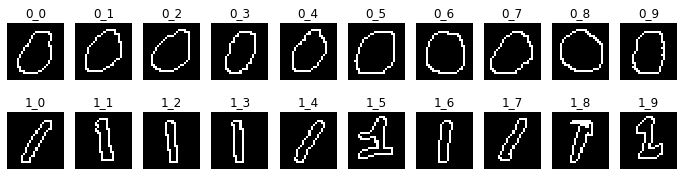

In [29]:
#create the contour imgs  
zeros_contours=get_contours(zeros_im)
ones_contours=get_contours(ones_im)

# Plot contours 
display(zeros_contours, ones_contours)

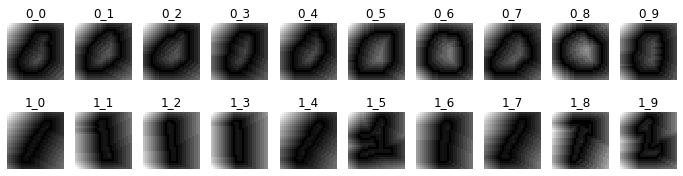

In [30]:
#create the contour maps from the contour images 
zeros_map=distance_map(zeros_contours)
ones_map=distance_map(ones_contours)

display(zeros_map, ones_map)

In [31]:
# calculate similarity matrix 
images_contour = zeros_map+ones_map
images = zeros_contours+ones_contours
dist=np.zeros((20,20))

for idx1, im1 in enumerate(images_contour[:-1]): #stops at one before the last  
    v=im1.shape[0]
    h=im1.shape[1]
    for idx2, im2 in enumerate(images[idx1+1:]): #starts one after im1
        idx2+=idx1+1
        sum_=0  # for distance between im2 and im1 
        for i in range(v): 
            for j in range(h):
                if im2[i][j] > 0: sum_ += im1[i][j]**2 #im1 already the distance to the contour of the real image 
        dist[idx1, idx2] = np.sqrt((1/(v*h)) * sum_)
        dist[idx2, idx1] = dist[idx1, idx2]
        

In [32]:
#calculate prediction matrix from a given distance matrix
def calculate_prediction_matrix(dist_matrix):
    pred_matrix = np.zeros((dist_matrix.shape[0], 2)) #same size as the given matrix 
    nb_element = dist_matrix.shape[1] // 2
    for i in range(dist_matrix.shape[0]):
        zeros = dist_matrix[i, :nb_element]
        ones = dist_matrix[i, nb_element:]
        dist_to_zeros = np.average(zeros[np.nonzero(zeros)])
        dist_to_ones = np.average(ones[np.nonzero(ones)])
        if dist_to_zeros < dist_to_ones:
            pred_matrix[i, 0] = 1
        else:
            pred_matrix[i, 1] = 1
    return pred_matrix == 1

#### Contour map without invariance 

In [33]:
dist_pred = calculate_prediction_matrix(dist)

Text(0.5, 24.0, 'Predicted class (red: attributed class)')

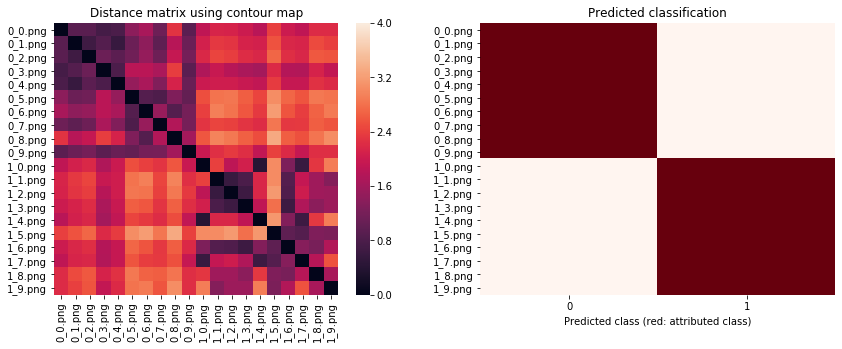

In [34]:
names=zeros_names+ones_names

plt.figure(figsize=(14,5))

plt.subplot(121)
plt.title('Distance matrix using contour map')
sn.heatmap(dist, xticklabels=names, yticklabels=names, vmin=0, vmax=4)

plt.subplot(122)
plt.title('Predicted classification')
sn.heatmap(dist_pred, yticklabels=names, xticklabels=['0', '1'], cbar=False, cmap='Reds')
plt.xlabel('Predicted class (red: attributed class)')

##### Analysis and discussion 
Here we obtain a heat map representing the values of the Chamfer distance for each one-on-one comparison between our contour maps set and the contours of the digits as they are. The matrix is symetric. We can see lower distances in the top left and bottom right corners of the matrix. As it correponds to the inter-set comparisons, it makes sense. Looking at the prediction matrix, it seems like we have perfect prediction. All the 0s are attributed to the 0-set and respectively for the 1s. 


#### New implementation with optimal transformation
Even if the images in a same class are similar, their "exact" distance can be different because of differences in the hand-writing and so differences in the orientation of the number or its exact position in the image. To mitigate the small variations between images of a same class, one can first look for the optimal distance between 2 images before using it to assert their similarities. In other words, one can look for the optimal transformation of the contour of an image to fit as best as possible the contour map of the other one so that the obtained distance is the smallest possible. 
 
In order to do that, we define the kind of transformations we want the distance to be invariant to. We use the functions defined at the beggining of the notebook. We choose rotation and translation on the x-axis or the y-axis as, considering the data set, we can say that scaling won't happen. We tried to do both x - and y- axis at the same time but the computation was too long. To make the distance invariant, we calculate it for each set of transformation and keep the one that gives the smallest distance. From this new distances, we create a similar matrix that we plot as previously as a heat map. We make sure to have the same scale of colours to be able to compare both heat maps (before and after optimal transformation). 

##### Rotation and x-Translation Invariant
We first calculate the new matrix with transformations invariance for rotation and horizontal translation. 

In [52]:
dist_transfo_x=np.zeros((20,20))

for idx1, im1 in enumerate(images_contour[:-1]): #stops at one before the last  
    v=im1.shape[0]
    h=im1.shape[1]
    
    for idx2, im2 in enumerate(images[idx1+1:]): #starts one after im1
        min_dist=9999 #dist for the best transformation of im2 
        idx2+=idx1+1
        
        for rot in range(0, 360, 15): #rotation given to im2
            for trans_x in range(-4, 5, 1): #x-translation given to im2
                
                im2_transfo = skimage_rotate(translation_x(im2,trans_x),rot)
                sum_=0  # for distance between im2 and im1 

                for i in range(v): 
                    for j in range(h):
                        if im2_transfo[i][j] > 0: sum_ += im1[i][j]**2 #calculate the sum for given transfo

                #if transfo gives smaller dist than the best: new best
                new_dist = np.sqrt((1/(v*h)) * sum_)
                min_dist = np.minimum(new_dist,min_dist)
                
        #once all the transfo tried: dist added to the matrix 
        dist_transfo_x[idx1, idx2] = min_dist
        dist_transfo_x[idx2, idx1] = dist_transfo_x[idx1, idx2]

##### Rotation and y-Translation invariant

Then we calculate the same matrix but with invariance to rotation, still, and vertical translation.

In [53]:
dist_transfo_y=np.zeros((20,20))

for idx1, im1 in enumerate(images_contour[:-1]): #stops at one before the last  
    v=im1.shape[0]
    h=im1.shape[1]
    
    for idx2, im2 in enumerate(images[idx1+1:]): #starts one after im1
        min_dist=9999 #dist for the best transformation of im2 
        idx2+=idx1+1
        
        for rot in range(0, 360, 15): #rotation given to im2
            for trans_y in range(-4, 5, 1): #y-translation given to im2
                
                im2_transfo = transform.rotate(translation_y(im2,trans_y),rot)
                sum_=0  # for distance between im2 and im1 

                for i in range(v): 
                    for j in range(h):
                        if im2_transfo[i][j] > 0: sum_ += im1[i][j]**2 #calculate the sum for given transfo

                #if transfo gives smaller dist than the best: new best
                new_dist = np.sqrt((1/(v*h)) * sum_)
                min_dist = np.minimum(new_dist,min_dist)

        #once all the transfo tried: dist added to the matrix 
        dist_transfo_y[idx1, idx2] = min_dist
        dist_transfo_y[idx2, idx1] = dist_transfo_y[idx1, idx2]

Finally, we can compute the new maps and compare them to the map that we had before the transformation-invariance. 

##### Comparison of the obtained matrix 

In [54]:
#calculation of the classification 
dist_transfo_x_pred = calculate_prediction_matrix(dist_transfo_x)
dist_transfo_y_pred = calculate_prediction_matrix(dist_transfo_y)

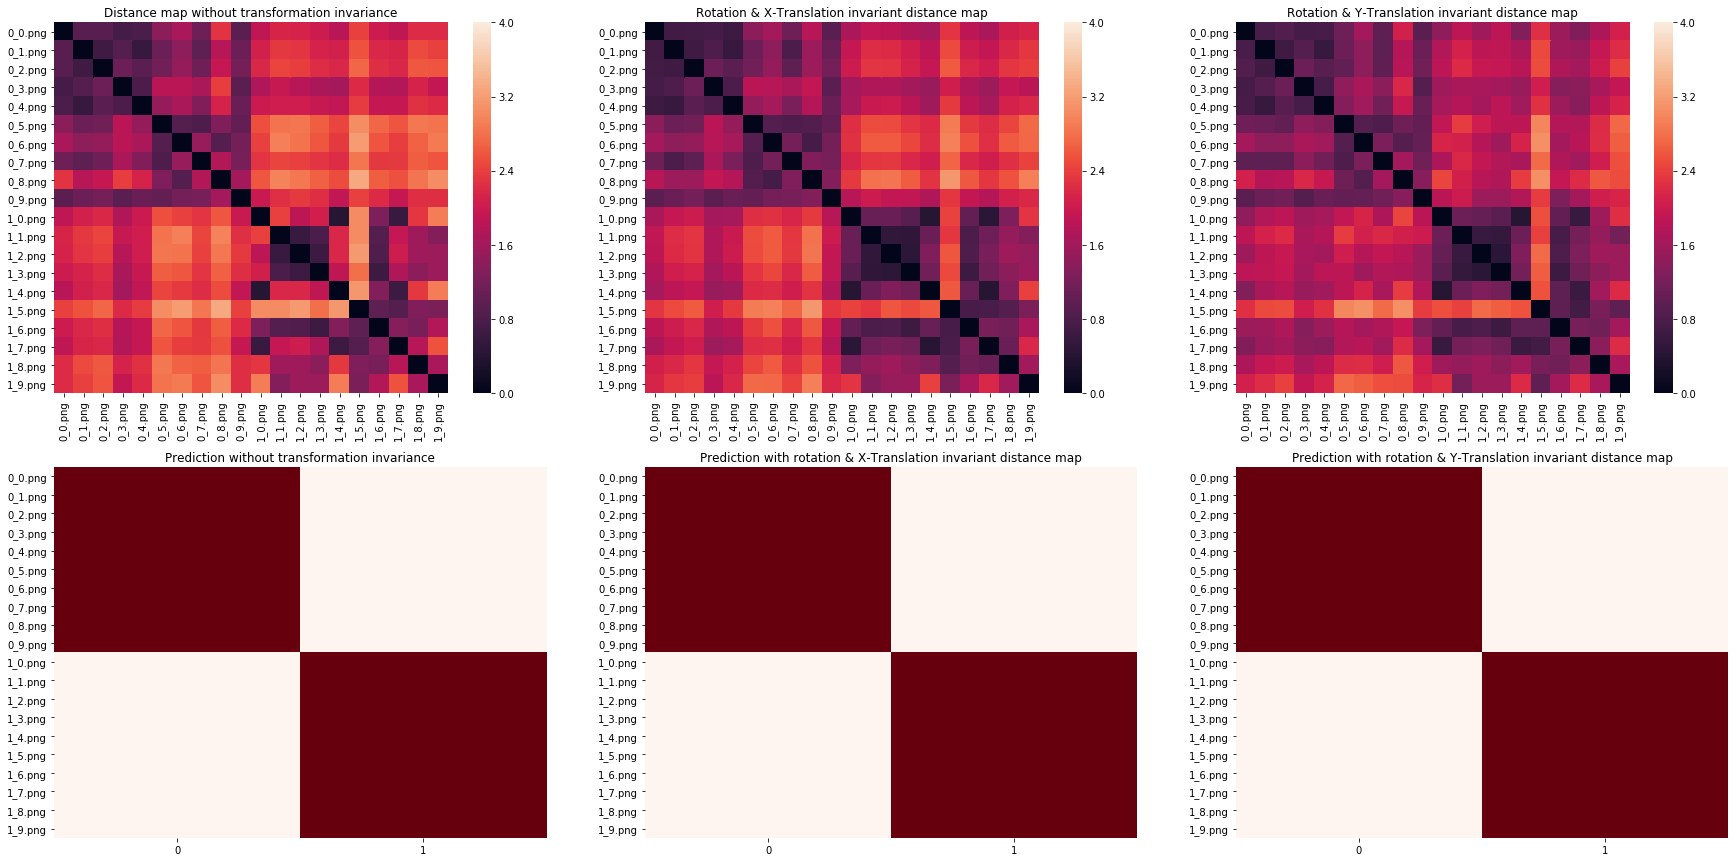

In [55]:
#names of the labels on the heatmaps
names=zeros_names+ones_names

fig = plt.figure(figsize=[30,15])

#distance map without optimal transformation 
ax = fig.add_subplot(2,3,1)
sn.heatmap(dist, ax=ax, xticklabels=names, yticklabels=names, vmin=0, vmax=4)
ax.set_title('Distance map without transformation invariance')

#dist map with optimal transfo on rotation and x translation
ax = fig.add_subplot(2,3,2)
sn.heatmap(dist_transfo_x, ax=ax, xticklabels=names, yticklabels=names, vmin=0, vmax=4)
ax.set_title('Rotation & X-Translation invariant distance map')

#dist map with optimal transfo on rotation and x translation
ax = fig.add_subplot(2,3,3)
sn.heatmap(dist_transfo_y, ax=ax, xticklabels=names, yticklabels=names, vmin=0, vmax=4)
ax.set_title('Rotation & Y-Translation invariant distance map')

ax = fig.add_subplot(2,3,4)
sn.heatmap(dist_pred, yticklabels=names, xticklabels=['0', '1'], cbar=False, cmap='Reds')
ax.set_title('Prediction without transformation invariance')

#dist map with optimal transfo on rotation and x translation
ax = fig.add_subplot(2,3,5)
sn.heatmap(dist_transfo_x_pred, yticklabels=names, xticklabels=['0', '1'], cbar=False, cmap='Reds')
ax.set_title('Prediction with rotation & X-Translation invariant distance map')

#dist map with optimal transfo on rotation and x translation
ax = fig.add_subplot(2,3,6)
sn.heatmap(dist_transfo_y_pred, yticklabels=names, xticklabels=['0', '1'], cbar=False, cmap='Reds')
ax.set_title('Prediction with rotation & Y-Translation invariant distance map')

plt.show()

#### Analysis and discussion
As the results were already good conserning the assignation of the single images to the classes, the results are not so much better. One can still see that almost all comparison presents a smaller distance (darker box).

### 2. Freeman code (or chain code)
Another way to get a description of the shapes based on contours is to use the Freeman code (or chain code). The principle of the method here is to "convert" the contour to a chain of numbers, which is then way more easy to analyse. 

To get the Freeman code, one starts at a point on the contour and go through the all contour one pixel at a time. For each pixel, one looks at the orientation of its neighbour pixel that is part of the contour. For each position, one assigns a number and add it to the chain. Once the contour lap is finished, the resulting chain represents accuralty the contour. Then, it is easy to just compare the chains correponding to each image, using an edit distance. The edit distance calculates the similarties between 2 chains by calculating the minimal number of operation requireed to go from one to the other. 

To do so, we fist start by reusing the `neighbours` function from the previous method but this time not separating the 4- and 8- neighbours. We also create a function `orientation` that, given 2 neighbour points, returns the orientation of one with respect to the other. Then, we easily created a chain for each image. From those chains, we effectuate a comparison one-by-one using the edit distance and form those distance, obtain a matrix similar to the ones obtained in the Contour Map method. We display it with a heat map too.

In [56]:
def neighbours(point, im):
    x = point[0]
    y = point[1]
    
    list_neighbours = [[x+1,y],[x+1, y+1],[x,y+1],[x-1,y+1],
                       [x-1,y],[x-1, y-1],[x, y-1], [x+1, y-1]]
    list_neighbours_final = list_neighbours.copy()
    
    for p in list_neighbours: 
        x, y = p
        if not(cond(x, y, im)): #not in the interval
            list_neighbours_final.remove(p)

    return list_neighbours_final

def orientation(p1, p2, im):
    #p1 the current point and p2 the next point on the contour (neighbour)
    orientation=0
    neigh=neighbours(p1, im)
    for n in range(len(neigh)): #determine the orientation of the neighbour point
        if p2[0] == neigh[n][0] and p2[1] == neigh[n][1]: #if p2 is the nth neigh of p1 
            orientation = n #orientation is n
            break 
    return orientation #return n that will be added to the chain

In [57]:
def freeman(im_set): 
    chain_set = []
    
    for im in im_set:
        
        #get the contours 
        contours = measure.find_contours(im, 0)
        #get the bigger one = exterior one (don't want the inner contour for the 0s) 
        exterior = max(contours, key=lambda x: len(x)).astype(np.float32)

        chain=[]
        for i in range(len(exterior[:-1])): # for each px of the contour
            current = exterior[i]
            next_ = exterior[i+1]
            #add corresponding bit for the position of next neigh 
            chain.append(orientation(current, next_, im)) #get the orientation of next one with respect to current one 
            
        chain_set.append(chain)
        
    return chain_set 
    

In [58]:
#get the freeman chains for each image
images = zeros_im.tolist()+ones_im.tolist() 
chain_set = freeman(images)

#get the edit distance of the chains to one another 
dist=np.zeros((20,20))

for idx1, ch1 in enumerate(chain_set[:-1]): 
    for idx2, ch2 in enumerate(chain_set[idx1+1:]):
        idx2+=idx1+1
        dist[idx1, idx2] = editdistance.eval(ch1, ch2)
        dist[idx2, idx1] = dist[idx1, idx2]
    

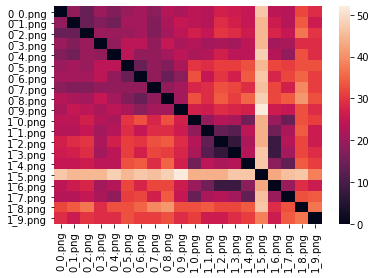

In [59]:
names=zeros_names+ones_names
sn.heatmap(dist, xticklabels=names, yticklabels=names)

#### Analysis and discussion
Even if the results are not obvious, we can distinguish a separation between the two classes with small edit distances in the upper left and bottom right quarters, compared to the two remaining quarters, and so images inside a same class are closer than with outsiders. 

### 3. Region-based descriptors
By considering the image as a whole and not only using its contour, there are also pleny of features that we can extract from a 2D shape. 

Considering the shapes of the 2 classes, we decided to calculate the compacity and the elongation for each image. We hypothtise that the zeros-images would have a small compacity as it is close to a circle and a small elongation while the ones-class would have a high compacity and a high elongation and that, as a result, the discrepency between both classes would be visible.

In [60]:
def shape_based(im_set): 

    compacity, elongation = [], []
    
    for im in im_set:
        #get contours 
        contours = measure.find_contours(im, 0)
        #get the external contour 
        longest_contour = max(contours, key=lambda x: len(x)).astype(np.float32)

        #compacity based on comparison with compacity of a circle
        area=cv2.contourArea(longest_contour)
        perimeter=cv2.arcLength(longest_contour, True)
        compacity.append(perimeter**2/area)

        #elongation based on ratio of eigenvalues 
        eigvals = measure.inertia_tensor_eigvals(im)
        elongation.append(np.sqrt(eigvals[0]/eigvals[1]))

    return compacity, elongation

No handles with labels found to put in legend.


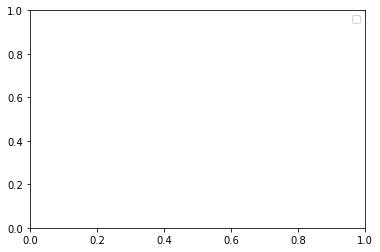

In [100]:
#calculate features for each image
compacity_0, elongation_0 = shape_based(zeros_im)
compacity_1, elongation_1 = shape_based(ones_im)

#display features 
fig = plt.figure()

ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Compacity')
ax.set_ylabel('Elongation')

ax.scatter(compacity_0, elongation_0, marker='+', color='r', label="Zeros")
ax.scatter(compacity_1, elongation_1, marker='+', color='b', label="Ones")
ax.set_title('Compacity VS Elongation')

plt.legend()
plt.show()

#### Analysis and discussion
The results are as expected. We clearly see that the zeors-images are grouped together with a small elongation and small compacity. For the ones-images, it is less obvious that they are part of a same class. This is due once again to the differences of hand-writting that change a lot the features chosen. For example, one can see the images 1_5 and 1_9 are less elongated compared to the other ones. Looking at the image, it makes sense because contrarly to the others, those ones were not written as "sticks" only but have more details such as a small line perpendicular to the stick at the bottom.  

## Part 2: New digits added 
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

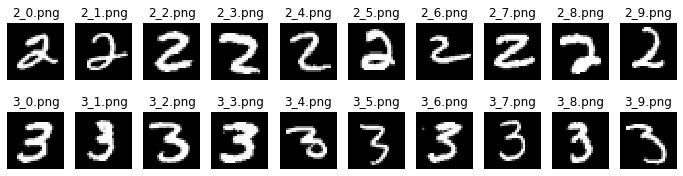

In [62]:
#  Load zeros
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load ones
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier Descriptors 

We start by analyzing the Fourier descriptor chosen in Part 1 on the twos and threes.

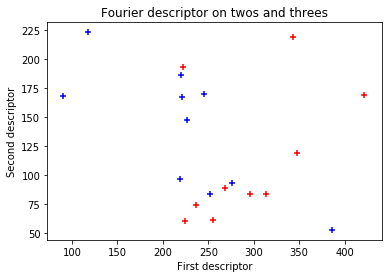

In [63]:
(twos_desc, threes_desc) = get_descriptors(twos_im, threes_im, get_fourier_descriptor_translation_invariance)

display_2d_descriptors(twos_desc, threes_desc, 'Fourier descriptor on twos and threes')

##### Analysis 
It seems that For twos and threes, the descriptor performs badly, with no clear separation boundary.

We will now plot the results for all the digits. 

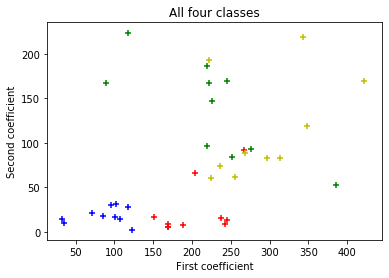

In [64]:
(zeros_desc, ones_desc) = get_descriptors(zeros_im, ones_im, get_fourier_descriptor_translation_invariance)
(twos_desc, threes_desc) = get_descriptors(twos_im, threes_im, get_fourier_descriptor_translation_invariance)


plt.figure()

plt.scatter(zeros_desc[:,0], zeros_desc[:,1], marker='+', c='b')
plt.scatter(ones_desc[:,0], ones_desc[:,1], marker='+', c='r')
plt.scatter(twos_desc[:,0], twos_desc[:,1], marker='+', c='g')
plt.scatter(threes_desc[:,0], threes_desc[:,1], marker='+', c='y')

plt.xlabel('First coefficient')
plt.ylabel('Second coefficient')

plt.title('All four classes')
plt.show()

##### Analysis 
Interestingly enough, the zeros are very well separated from the rest of the digits. We can even observe some clustering tendency, but there is no clear linear separation.

One possible option would be to add another dimension to the descriptor, by using the second, third and fourth coefficients.

In [65]:
def get_fourier_descriptor_3d(r):
    fft = get_fourier_contour(r)
    descriptor = np.absolute(fft[1:4])
    return descriptor

In [66]:
(zeros_desc, ones_desc) = get_descriptors(zeros_im, ones_im, get_fourier_descriptor_3d)
(twos_desc, threes_desc) = get_descriptors(twos_im, threes_im, get_fourier_descriptor_3d)

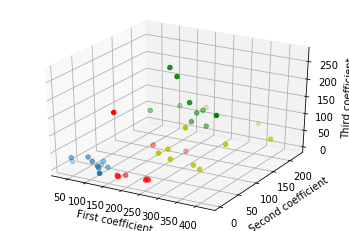

In [67]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(zeros_desc[:,0], zeros_desc[:,1], zeros_desc[:,2])
ax.scatter(ones_desc[:,0], ones_desc[:,1], ones_desc[:,2], c='r')
ax.scatter(twos_desc[:,0], twos_desc[:,1], twos_desc[:,2], c='g')
ax.scatter(threes_desc[:,0], threes_desc[:,1], threes_desc[:,2], c='y')
ax.set_xlabel('First coefficient')
ax.set_ylabel('Second coefficient')
ax.set_zlabel('Third coefficient')

plt.show()

Using three coefficients, it seems like we can distinguish the different clusters for the digits a little better than when using only two descriptors. 

### 2.3 Additional method(s) and conclusion
Add your implementations and discussions here

### 1. Contour map 
Here we reuse the same functions as when it was only 0s and 1s. We expect to see the same results: darker squares around the diagonal of the symmetric matrix, indicating that the images in a same class are similar and, most of all, more similar than when not in the same class. 

In [68]:
#get contours of the new imgs
twos_contours=get_contours(twos_im)
threes_contours=get_contours(threes_im)

#calculate distance map for the 2 new classes
twos_map=distance_map(twos_contours)
threes_map=distance_map(threes_contours)

#create the set of images 
images_contour_new = zeros_map+ones_map+twos_map+threes_map
images_new = zeros_contours+ones_contours+twos_contours+threes_contours

dist_new=np.zeros((40,40))

for idx1, im1 in enumerate(images_contour_new[:-1]): #stops at one before the last  
    v=im1.shape[0]
    h=im1.shape[1]
    for idx2, im2 in enumerate(images_new[idx1+1:]): #starts one after im1
        idx2+=idx1+1
        sum_=0  # for distance between im2 and im1 
        for i in range(v): 
            for j in range(h):
                if im2[i][j] > 0: sum_ += im1[i][j]**2 #im1 already the distance to the contour of the real image 
        dist_new[idx1, idx2] = np.sqrt((1/(v*h)) * sum_)
        dist_new[idx2, idx1] = dist_new[idx1, idx2]

In [69]:
#calculate prediction matrix from a given distance matrix for 4 digits 
def calculate_prediction_matrix_new(dist_matrix):
    
    #same size as the given matrix in the y and 4 categories for the chosen class
    pred_matrix = np.zeros((dist_matrix.shape[0], 4))  
    nb_element = dist_matrix.shape[1] // 4
    
    for i in range(dist_matrix.shape[0]):
        
        zeros = dist_matrix[i, :nb_element]
        ones = dist_matrix[i, nb_element:(2*nb_element)]
        twos = dist_matrix[i, (2*nb_element):(3*nb_element)]
        threes = dist_matrix[i, (3*nb_element):]
        
        dist_to_zeros = np.average(zeros[np.nonzero(zeros)])
        dist_to_ones = np.average(ones[np.nonzero(ones)])
        dist_to_twos = np.average(twos[np.nonzero(twos)])
        dist_to_threes = np.average(threes[np.nonzero(threes)])
        
        pred = np.argmin([dist_to_zeros,dist_to_ones,dist_to_twos,dist_to_threes])
        pred_matrix[i, pred] = 1
        
    return pred_matrix == 1


In [70]:
#calculate classification
dist_pred_new = calculate_prediction_matrix_new(dist_new)

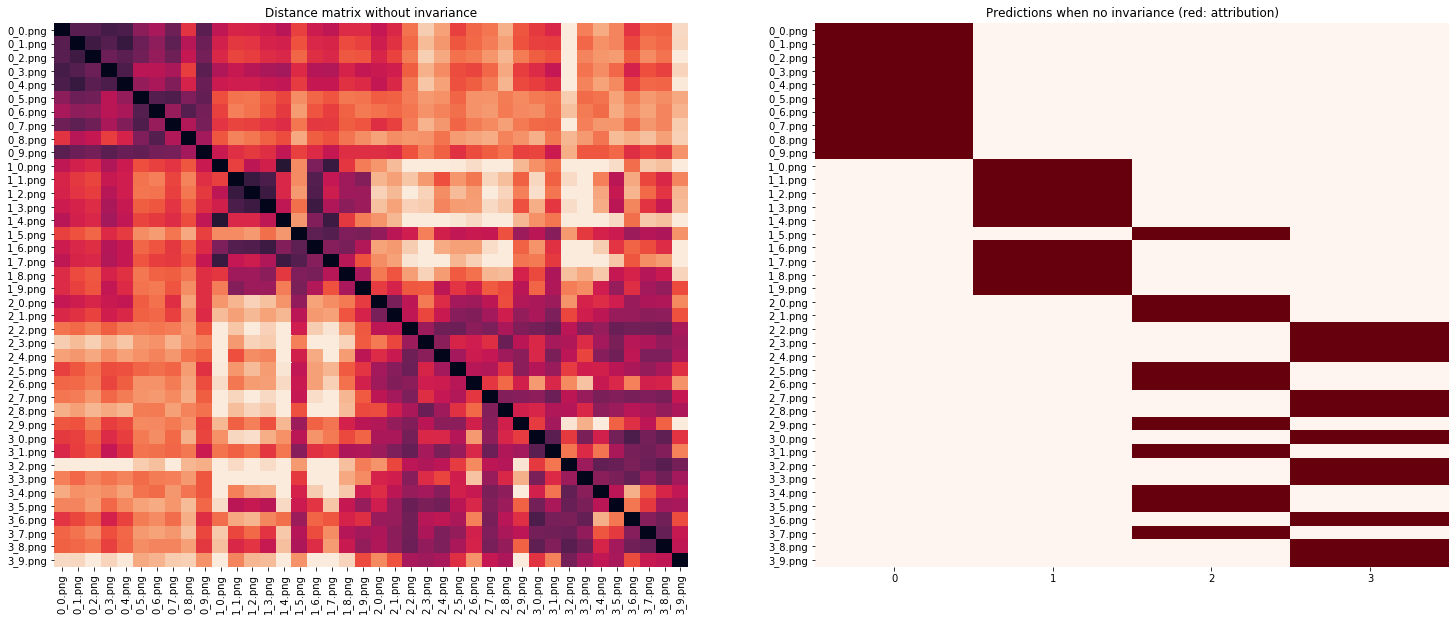

In [81]:
names=zeros_names+ones_names+twos_names+threes_names

#distance map for all the digits 
fig = plt.figure(figsize=[25,10])

plt.subplot(1,2,1)
sn.heatmap(dist_new, xticklabels=names, yticklabels=names,  cbar=False, vmin=0, vmax=4)
plt.title("Distance matrix without invariance")

plt.subplot(1,2,2)
sn.heatmap(dist_pred_new, yticklabels=names, xticklabels=['0', '1', '2', '3'], cbar=False, cmap='Reds')
plt.title("Predictions when no invariance (red: attribution)")


plt.show()

#### Analysis and discussion 
First, we don't have to talk too much about the upper left part of the matrix as it is the same as in the first part, where we compared 0s to 1s. Looking at the prediction matrix, Image 1_5 was misclassified as a 2, which makes sense as it is the only 1 which is graphically more elaborated with a lower perpendicular bar and that could be taken as a 2. Concerning the new parts of the matrix we can't really see distinct darker squares on the diagonal for the 2s and the 3s. It is probably due to the fact that people have a lot of ways to do 2s and 3s compared to 1s and 0s, depending on their hand-writing. Hence some of the images will be close to each other because it's the same style but they can also be really far. Hence, looking at the prediction matrix, elements for sets of 2s and 3s are attributed to one of the two classes but not necessarly rightly. 

We can see that, except for Image 1_5, there is a high difference for 1s compared to 2s and 3s as the color there is really light. It makes sense because most of the images we have for 1s are really simple (only a "stick") compared the 2s and 3s which are way more elaborated with loops and all. As a result the distance between those classes is much higher. 

#### Transformation-invariant contour maps 
Here again, we can perform transformations so that the distance is invariant to them by finding the optimal set of transformations to obtain the smallest distance from it. For computational reasons, we are not able to compute the matrix after transformation invariance for the all set of comparisons (from 0s to 3s) so we only compare the twos-images and the threes-images. 

In [75]:
dist_transfo_y_sec=np.zeros((20,20))
images_contour_sec = twos_map+threes_map
images_sec = twos_contours+threes_contours

for idx1, im1 in enumerate(images_contour_sec[:-1]): #stops at one before the last  
    v=im1.shape[0]
    h=im1.shape[1]
    
    for idx2, im2 in enumerate(images_sec[idx1+1:]): #starts one after im1
        min_dist=9999 #dist for the best transformation of im2 
        idx2+=idx1+1
        
        for rot in range(0, 360, 15): #rotation given to im2
                for trans_y in range(-4, 5, 1): #y-translation given to im2
                
                    im2_transfo = transform.rotate(translation_y(im2,trans_y),rot)
                    sum_=0  # for distance between im2 and im1 

                    for i in range(v): 
                        for j in range(h):
                            if im2_transfo[i][j] > 0: sum_ += im1[i][j]**2 #calculate the sum for given transfo

                    #if transfo gives smaller dist than the best: new best
                    new_dist = np.sqrt((1/(v*h)) * sum_)
                    min_dist = np.minimum(new_dist,min_dist)
                
        #once all the transfo tried: dist added to the matrix 
        dist_transfo_y_sec[idx1, idx2] = min_dist
        dist_transfo_y_sec[idx2, idx1] = dist_transfo_y_sec[idx1, idx2]

In [76]:
dist_transfo_y_sec_pred = calculate_prediction_matrix(dist_transfo_y_sec)

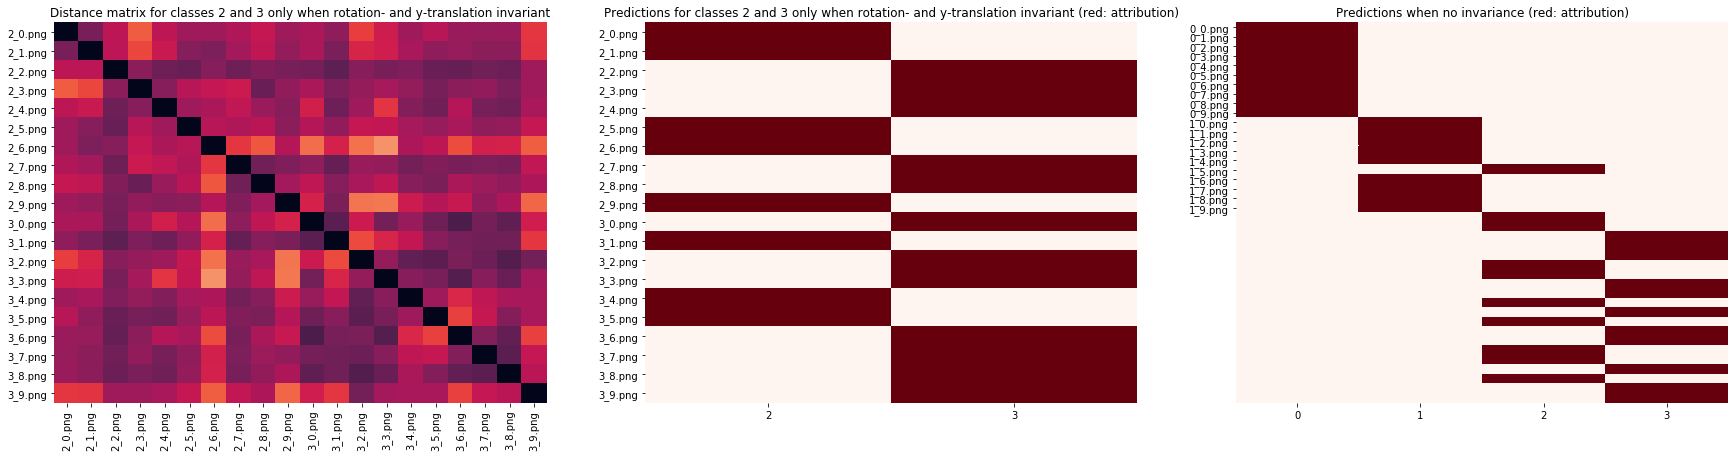

In [88]:
names_sec=twos_names+threes_names

#distance map for all the digits 
fig = plt.figure(figsize=[30,7])

plt.subplot(1,3,1)
sn.heatmap(dist_transfo_y_sec, xticklabels=names_sec, yticklabels=names_sec, cbar=False, vmin=0, vmax=4)
plt.title("Distance matrix for classes 2 and 3 only when rotation- and y-translation invariant")


plt.subplot(1,3,2)
sn.heatmap(dist_transfo_y_sec_pred, yticklabels=names_sec, xticklabels=['2', '3'], cbar=False, cmap='Reds')
plt.title("Predictions for classes 2 and 3 only when rotation- and y-translation invariant (red: attribution)")

plt.subplot(1,3,3)
sn.heatmap(dist_pred_new, yticklabels=names, xticklabels=['0', '1', '2', '3'], cbar=False, cmap='Reds')
plt.title("Predictions when no invariance (red: attribution)")

plt.show()

#### Analysis and discussion 
There's only one correction of misclassification compared to the prediction matrix without invariance. However, looking at the distance matrix, by comparing to the bottom right corner of the previous heatmap (which corresponds to the comparison between 2s and 3s), we can see improvement as pretty much all the one-to-one comparisons have a lower distance (darker).

One way to improve the results would be to be able to find all the optimal transformations at once and optain the smallest distance possible. We suppose that it would make inter-digits comparisons better to intra-digits comparisons as it improves all the comparison but it would still be better. The major problem for the new digits is the variability in hand writting. To make it less important, one would need to add features to the classification.  

### Freeman code

We reuse the same functions as before and add the new digits in the calculations and comparisons. 

In [98]:
#get the freeman chains for each image 
images_freeman=zeros_im.tolist()+ones_im.tolist()+twos_im.tolist()+threes_im.tolist()
names_freeman=zeros_names+ones_names+twos_names+threes_names
chain_set = freeman(images_freeman)

#get the edit distance of the chains to one another 
dist_freeman_all=np.zeros((40,40))

for idx1, ch1 in enumerate(chain_set[:-1]): 
    for idx2, ch2 in enumerate(chain_set[idx1+1:]):
        idx2+=idx1+1
        dist_freeman_all[idx1, idx2] = editdistance.eval(ch1, ch2)
        dist_freeman_all[idx2, idx1] = dist_freeman_all[idx1, idx2]
    

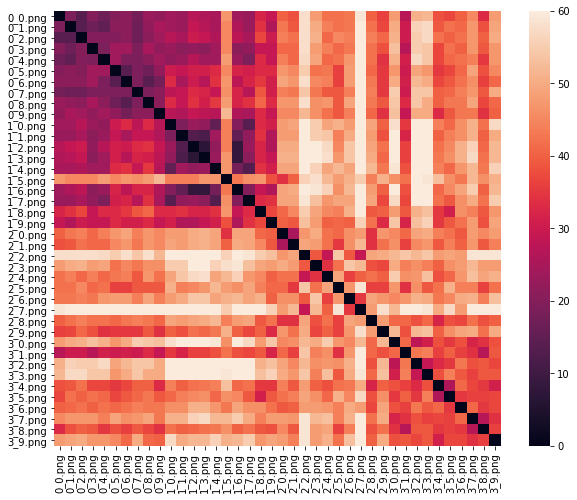

In [99]:
fig = plt.figure(figsize=[10,8])
sn.heatmap(dist_freeman_all, xticklabels=names_freeman, yticklabels=names_freeman, vmin=0, vmax=60)
plt.show()

#### Analysis and discussion 
What we would like to see here is darker squares around the diagonal of the matrix, corresponding to similar images from a same class. Indeed, here we can distinguish some sorts of squares mostly for 1s and 0s as we saw in the first part. We can also see a lighter but present square around the 3s but nothing significant for the 2s. 
The fact that 2s and 3s are easily really different from one person to another (different hand-writting) could explain why those numbers are less well clustered from the rest compared to 0s and 1s that are more simple and as a result more "universally" done. 

### Region-based description
Unfortunalty for this method, we expect bad results as the features chosen previously were more specific to the 0s and 1s. We still plot the results.

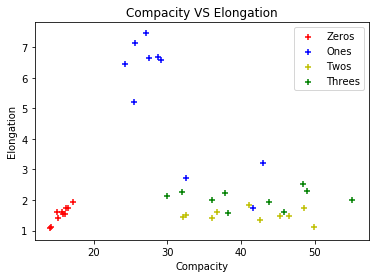

In [102]:
#calculate features 
compacity_2, elongation_2 = shape_based(twos_im)
compacity_3, elongation_3 = shape_based(threes_im)

#display features 
fig = plt.figure()

ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Compacity')
ax.set_ylabel('Elongation')

ax.scatter(compacity_0, elongation_0, marker='+', color='r', label="Zeros")
ax.scatter(compacity_1, elongation_1, marker='+', color='b', label="Ones")
ax.scatter(compacity_2, elongation_2, marker='+', color='y', label="Twos")
ax.scatter(compacity_3, elongation_3, marker='+', color='g', label="Threes")

ax.set_title('Compacity VS Elongation')

plt.legend()
plt.show()

As there are many more points adding the 2 other digits, it is more complicated to distinguish the classes. We can still see that the 0s form a separate class from the others. The 3s and 2s are really not distinguishable and mix themselves with the 1s that are more "complex" at the bottom right. It makes sense with what was expected. Indeed the features chosen in this part are specific to the 0s and 1s geometry so by adding more elaborated digits, it loses its efficacity.

One way to obtain more distinguishable classes would be to add features.